# Assignment 5 : Reglarized Linear Regression and Bias vs. Variance

Module imports

In [151]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, fmin_cg
import scipy.io as sio
import statistics as stats

Load input data:

In [152]:
file_name = 'ex5data1.mat'

def read_file(file_name):
    data = sio.loadmat(file_name)

    # training set
    X, y = data['X'], data['y']

    # test set
    X_test, y_test = data['Xtest'], data['ytest']

    # cross-validation set
    X_CV, y_CV = data['Xval'], data['yval']


    m, n = X.shape[0], X.shape[1]
    m_test = X_test.shape[0]
    m_CV = X_CV.shape[0]
    
    return X, y, X_test, y_test, X_CV, y_CV, m, n, m_test, m_CV

Plotting the training data:

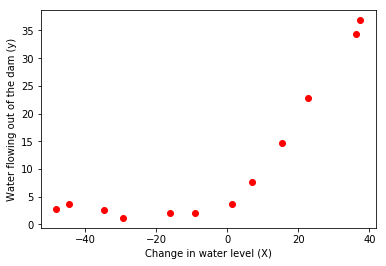

In [153]:
X, y, X_test, y_test, X_CV, y_CV, m, n, m_test, m_CV = read_file('ex5data1.mat')
plt.scatter(X.flatten(), y.flatten(), c='r')
plt.xlabel('Change in water level (X)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

## Regularized Linear Regression

Reglarized Linear Regression methods:

In [154]:
def cost(theta, X, y, lmd):
    m = X.shape[0]
    bias = np.ones((m, 1))
    X = np.append(bias, X, axis=1)
    theta = theta.reshape((theta.size, 1))
    
    # Not regularized yet
    ans = np.matmul(X, theta)
    ans = ans - y
    ans = np.matmul(ans.T, ans)
    ans = (1 / (2 * m)) * ans
    
    
    # Regularization term
    reg = np.matmul(theta[1:, ...].T, theta[1:, ...])
    reg = (lmd / (2 * m)) * reg
    
    return (ans + reg).flatten()[0]


def gradient(theta, X, y, lmd):
    m = X.shape[0]
    bias = np.ones((m, 1))
    X = np.append(bias, X, axis=1)
    
    theta = theta.reshape((theta.size, 1))
    
    # Not regularized yet
    grad = np.matmul(X, theta)
    grad = np.matmul(X.T, grad - y)
    grad = (1 / m) * grad
    
    # Regularization term
    reg = theta[1:, ...]
    reg = (lmd / m) * reg
    reg = reg.flatten()
    reg = np.insert(reg, 0, theta[0][0])
    reg = reg.reshape(theta.shape)
    
    return (grad + reg).flatten()

Fitting a linear function without regularization

In [155]:
theta = np.zeros((1, n+1)).flatten()
lmd = 0
theta1 = minimize(method='CG', fun=cost, jac=gradient, args=(X, y, lmd), x0=theta).x
theta2 = minimize(method='Nelder-Mead', fun=cost, args=(X, y, lmd), x0=theta).x
print('CG Cost: ', cost(theta1, X, y, 0))
print('Nelder-Mead Cost: ', cost(theta2, X, y, 0))

CG Cost:  43.78043590516538
Nelder-Mead Cost:  22.37390649553841


Which one is minimum?!
CG method gets stuck somewhere

In [156]:
theta = theta2

Plotting the linear fit:

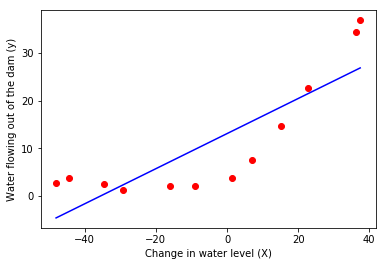

In [157]:
def h(x, theta, m, n):
    bias = 1
    theta = theta.reshape(theta.size, 1)
    x = list(x.ravel())
    x.insert(0, bias)
    x = np.array(x)
    ans = np.matmul(theta.T, x).flatten()
    return ans[0]
    

plt.scatter(X.flatten(), y.flatten(), c='r')
plt.xlabel('Change in water level (X)')
plt.ylabel('Water flowing out of the dam (y)')
x_min, x_max = min(X.flatten()), max(X.flatten())
x_arr = np.arange(x_min, x_max, 0.1)
y_arr = []
for x1 in x_arr:
    y_arr.append(h(x1, theta, m, n))
plt.plot(x_arr, y_arr, c='b')
plt.show()

## Learning Curves

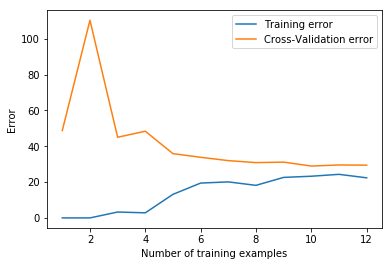

In [158]:
# getting a fit line for each number of training data and storing CV errors and train errors
tr_x = [] # training error x vals
tr_y = [] # training error y vals
cv_x = [] # cross validation error x vals
cv_y = [] # cross validation error y vals
lmd = 0

for i in range(1, m+1):
    tr_x.append(i)
    cv_x.append(i)
    my_X = X[0:i, ...]
    my_y = y[0:i, ...]
    my_theta = np.zeros((n, 1))
    my_theta = minimize(method='Nelder-Mead', fun=cost, args=(my_X, my_y, lmd), x0=theta).x
    tr_y.append(cost(my_theta, my_X, my_y, 0))
    cv_y.append(cost(my_theta, X_CV, y_CV, 0))

plt.plot(tr_x, tr_y, label='Training error')
plt.plot(cv_x, cv_y, label='Cross-Validation error')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend()
plt.show()

    
    

## Polynomial Regression

In [159]:
def normalize_features(X):
    X = X.T
    for i in range(X.shape[0]):
        mean = stats.mean(X[i])
        stdev = stats.stdev(X[i])
        X[i] = (X[i] - mean) / stdev
        
    # in this example we have only one column of X, so we have only one mean and one stdev
    return X.T, mean, stdev

def map_features(X, degree):
    res = []
    m = X.shape[0]
    for i in range(m):
        cur = []
        for j in range(1, degree+1):
            # discard the 0 power (bias)
            cur.append(X[i][0] ** j)
        res.append(cur)
    return np.array(res)

def map_single_feature(x1, degree):
    res = []
    for i in range(1, degree+1):
        res.append(x1**i)
    arr = np.array(res)
    return arr.reshape((arr.size, 1))

In [160]:
X, y, X_test, y_test, X_CV, y_CV, m, n, m_test, m_CV = read_file('ex5data1.mat')

# before normalizing and polynomial mapping
original_X = read_file('ex5data1.mat')[0]

X, mean, stdev = normalize_features(X)
degree = 8
X = map_features(X, degree)
lmd = 0
theta = np.zeros((degree+1, 1)).flatten()
theta = minimize(method='CG', fun=cost, jac=gradient, x0=theta, args=(X, y, lmd), options={'disp': True}).x

         Current function value: 1.372372
         Iterations: 12
         Function evaluations: 68
         Gradient evaluations: 56


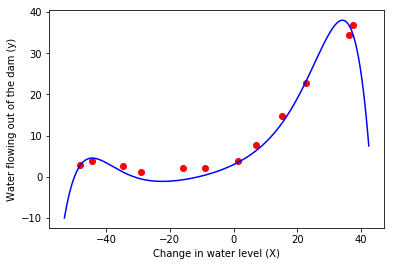

In [161]:
plt.scatter(original_X.flatten(), y.flatten(), c='r')
plt.xlabel('Change in water level (X)')
plt.ylabel('Water flowing out of the dam (y)')
x_min, x_max = min(original_X.flatten()) - 5, max(original_X.flatten()) + 5
x_arr = np.arange(x_min, x_max, 0.1)
y_arr = []
for x1 in x_arr:
    # normalize:
    x1 = (x1 - mean) / stdev
    x1 = map_single_feature(x1, degree)
    y_arr.append(h(x1, theta, m, degree))
plt.plot(x_arr, y_arr, c='b')
plt.show()

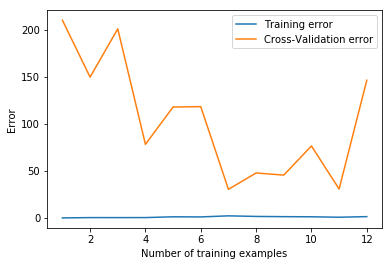

In [162]:
tr_x = [] # training error x vals
tr_y = [] # training error y vals
cv_x = [] # cross validation error x vals
cv_y = [] # cross validation error y vals
lmd = 0

X_CV, mean, stdev = normalize_features(X_CV)
X_CV = map_features(X_CV, degree)
degree = 8

for i in range(1, m+1):
    tr_x.append(i)
    cv_x.append(i)
    mytheta = np.zeros((degree+1, 1)).flatten()
    mytheta = minimize(method='CG', fun=cost, jac=gradient, x0=mytheta, args=(X[0:i, ...], y[0:i, ...], lmd)).x
    tr_y.append(cost(mytheta, X[0:i, ...], y[0:i], 0))
    cv_y.append(cost(mytheta, X_CV, y_CV, 0))
    
plt.plot(tr_x, tr_y, label='Training error')
plt.plot(cv_x, cv_y, label='Cross-Validation error')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend()
    
plt.show()

## Adjusting the regularization parameter

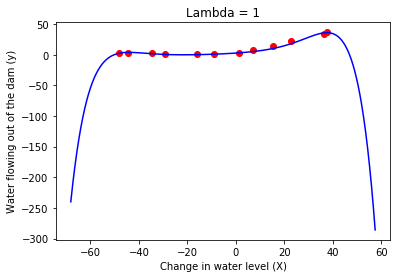

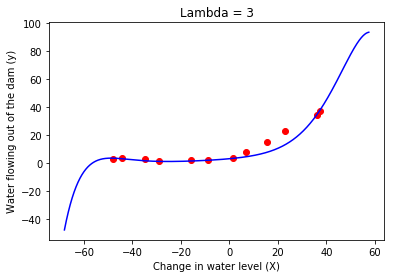

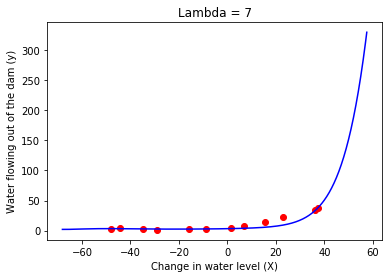

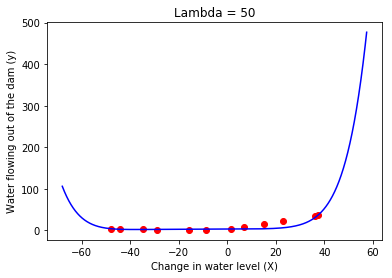

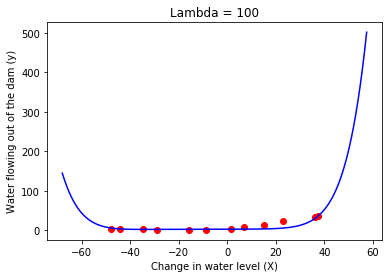

In [163]:
X, y, X_test, y_test, X_CV, y_CV, m, n, m_test, m_CV = read_file('ex5data1.mat')

# before normalizing and polynomial mapping
original_X = read_file('ex5data1.mat')[0]
degree = 8
X, mean, stdev = normalize_features(X)
X = map_features(X, degree)

# we have already seen what lmd=0 does, so let's go with 1, 3, 7, 50 and 100
for lmd in (1, 3, 7, 50, 100):
    # minimize cost
    theta = np.zeros((degree+1, 1)).flatten()
    theta = minimize(method='CG', fun=cost, jac=gradient, x0=theta, args=(X, y, lmd)).x
    
    # plot
    plt.scatter(original_X.flatten(), y.flatten(), c='r')
    plt.xlabel('Change in water level (X)')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.title('Lambda = {0}'.format(lmd))
    x_min, x_max = min(original_X.flatten()) - 20, max(original_X.flatten()) + 20
    x_arr = np.arange(x_min, x_max, 0.1)
    y_arr = []
    for x1 in x_arr:
        # normalize:
        x1 = (x1 - mean) / stdev
        x1 = map_single_feature(x1, degree)
        y_arr.append(h(x1, theta, m, degree))
    plt.plot(x_arr, y_arr, c='b')
    plt.show()